# Learning to Write using KerasNLP - An Introduction

In this notebook, you will learn to use [KerasNLP](https://keras.io/keras_nlp/) to load a pre-trained Large Language Model (LLM) - [GPT-2 model](https://openai.com/research/better-language-models) (originally invented by OpenAI).

This notebook is a modified version from the [original version](https://github.com/tensorflow/codelabs/tree/main/KerasNLP).

# Before you begin

Colab offers different kinds of runtimes. Make sure to go to **Runtime -> Change runtime type** and choose the GPU Hardware Accelerator runtime (which should have >12G System RAM and ~15G GPU RAM).

# Imports

Let's import the required libraries.

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-nlp.git@google-io-2023 tensorflow-text==2.12

In [ ]:
import numpy as np
import time

import keras_nlp
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text
from tensorflow import keras

# Introduction to Large Language Models (LLMs)

Large language models (LLMs) are a type of machine learning models that are trained on a large corpus of text data to generate outputs for various natural language processing (NLP) tasks, such as text generation, question answering, and machine translation.

LLMs are typically based on deep learning neural networks, such as the [Transformer architecture](https://arxiv.org/abs/1706.03762) invented by Google researchers in 2017, and are trained on massive amounts of text data, often involving billions of words. These models, such as Google [LaMDA](https://blog.google/technology/ai/lamda/) and [PaLM](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html), are trained with a large dataset from various data sources which allows them to generate output for many tasks.

LLMs are large because of their sheer size and the vast volumes of data on which they are trained, but at the core they are just language models that can predict the next word in a sentence. Language models do this by analyzing the words that have already been used in the sentence and then using that information to calculate the probability of each possible word. This way LLMs can generate coherent text based on user prompts. For a more pedagogical discussion on language models, you can refer to the [Stanford CS324 LLM course](https://stanford-cs324.github.io/winter2022/lectures/introduction/).

One of the challenges with LLMs is that they are computationally expensive to  run. For example, generating text with an LLM can take several seconds or even minutes on GPUs. This is particular challenging for mobile devices where there are very limited computing power and storage space. But LLMs of smaller scale (e.g., [GPT-2](https://openai.com/research/better-language-models) invented by OpenAI) are more manageable; you can run them fully on device and stil get very impressive results.

Reference:
- Google LaMDA: https://blog.google/technology/ai/lamda/
- Google PaLM: https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html
- Stanford LLM Course: https://stanford-cs324.github.io/winter2022/lectures/introduction/
- GPT-2: https://openai.com/research/better-language-models

# Introduction to KerasNLP

Large Language Models are complex to build and expensive to train from scratch. Luckily there are pretrained LLMs available for use right away. One toolkit that offers state-of-the-art pretrained models for free is [KerasNLP](https://keras.io/keras_nlp/).

KerasNLP is a natural language processing library that supports users through their entire development cycle. The workflows are built from modular components that have state-of-the-art preset weights and architectures when used out-of-the-box and are easily customizable when more control is needed. KerasNLP emphasizes in-graph computation for all workflows so that developers can expect easy productionization using the TensorFlow ecosystem, for example, deployment to mobile devices with TensorFlow Lite.

KerasNLP is a great choice for anyone who wants to build NLP models with Keras. It provides a high-level API for building NLP models, and it includes a variety of pre-trained models and modules. It is easy to use, and it provides a wide range of features. If you are new to NLP, KerasNLP is a great place to start with.

## Load a pre-trained GPT-2 model and generate some text

KerasNLP provides a number of pre-trained models, such as [Google Bert](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html) and [GPT-2](https://openai.com/research/better-language-models). You can see the list of models available in the [KerasNLP repository](https://github.com/keras-team/keras-nlp/tree/master/keras_nlp/models).

We load the GPT-2 model as you can see below:

In [ ]:
gpt2_tokenizer = keras_nlp.models.GPT2Tokenizer.from_preset("gpt2_base_en")
gpt2_preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=256,
    add_end_token=True,
)
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset("gpt2_base_en", preprocessor=gpt2_preprocessor)

Once the model is loaded, you can use it to generate some text right away. Run the cells below to give it a try. It's as simple as calling a single function *generate()*:

In [ ]:
start = time.time()

output = gpt2_lm.generate("I will learn machine learning to", max_length=200)
print("\nGPT-2 output:")
print(output.numpy().decode("utf-8"))

end = time.time()
print("TOTAL TIME ELAPSED: ", end - start)

Try another one:

In [ ]:
start = time.time()

output = gpt2_lm.generate("It's my life, it now or", max_length=200)
print("\nGPT-2 output:")
print(output.numpy().decode("utf-8"))

end = time.time()
print("TOTAL TIME ELAPSED: ", end - start)

Notice how much faster the second call is. This is because the computational graph is compiled in the 1st run and re-used in the 2nd behind the scene.

# More on the GPT-2 model from KerasNLP

While it may be sufficient to move on to the next step of finetuning the loaded model now, for the more curious you can better understand how LLMs are built by following this section.

You can check out the full GPT-2 model implementation in KerasNLP on [GitHub](https://github.com/keras-team/keras-nlp/blob/master/keras_nlp/models/gpt2/). But conceptually the GPT-2 causal language model can be hierarchically broken down into several modules in KerasNLP, all of which have a *from_preset()* function that loads a pretrained model:

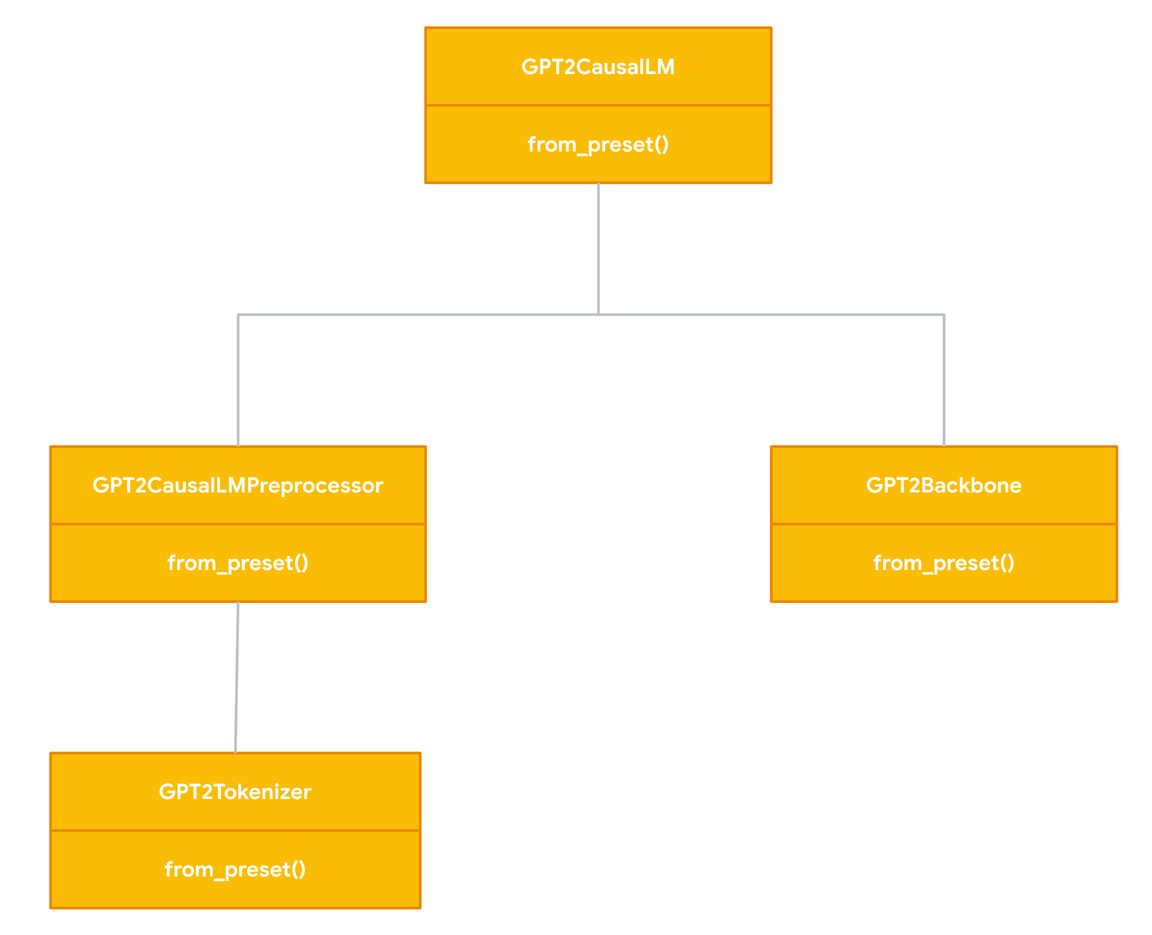

## GPT2Tokenizer

The tokenizer converts your text input into token IDs. There are different kinds of tokenizers; GPT-2 model uses the Byte-Pair Encoding (BPE) tokenizer. You can refer to this [Stanford lecture material](https://stanford-cs324.github.io/winter2022/lectures/modeling/#byte-pair-encoding) for further discussion on BPE tokenization.

In [ ]:
gpt2_tokenizer.tokenize(["Easy come, easy go, will you let me go"]).flat_values

## GPT2CausalLMPreprocessor

The preprocessor does additional processing, e.g., padding the tensor of token IDs to a specified length, after tokenziation is finished.

In [ ]:
ds = tf.data.Dataset.from_tensor_slices(["Easy come, easy go, will you let me go"])
preprocessed_ds = ds.map(gpt2_preprocessor)
output = next(iter(preprocessed_ds))

print('token ids:')
print(output[0]['token_ids'])

print('padding masks:')
print(output[0]['padding_mask'])

You can see that a lot of *50256*s are appended to the tensor of token IDs. *50256* is the *'end of sentence'* token for the GPT-2 model and is used to pad the tensor to the length as specified when the preprocessor was created.

Note that the length for the token ID tensor is 255, instead of 256 as specified in `sequence_length` when the preprocessor was created. This is because the label for language models is the next word; so intuititvely the input tensor is shifted toward the end by 1 as labels. Thus, the 256th element is truncated.

## GPT2Backbone

The backbone builds up the neural network and is where real actions happen. Due to the time limit, it's impossible to cover the entire [GPT-2 architecture](https://d4mucfpksywv.cloudfront.net/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) in this workshop (you can check out the full GPT-2 backbone implementation [here](https://github.com/keras-team/keras-nlp/blob/master/keras_nlp/models/gpt2/gpt2_backbone.py)). But at a high level GPT-2 is a decoder-only model and its core is a stack of [Transformer](https://en.wikipedia.org/wiki/Transformer_(machine_learning_model) blocks.

The Transformer architecture was invented by several Google researchers in the 2017 paper [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) and is now the foundational building block for many natural language processsing tasks. It's superior to recurrent and convolutional neural networks because it can better handle long-range dependeies and allows for significantly more parallelization.

You can follow a full Transformer implementation [tutorial](https://www.tensorflow.org/text/tutorials/transformer) at tensorflow.org to learn all the details. But at the core, the Transformer architecture relies on the 'Scaled Dot-Product Attention' (as in the left diagram below). Attention is a mechanism that enables a neural network to selectively focus on certain parts of the input data. 'Scaled Dot-Product Attention' is a specific type of attention, which mathematically is defined as:

$$
Attention(Q,K,V) = \operatorname{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

where:

* $Q$ is the query matrix

* $K$ is the key matrix

* $V$ is the value matrix

* $d_k$ is the dimension of the key matrix

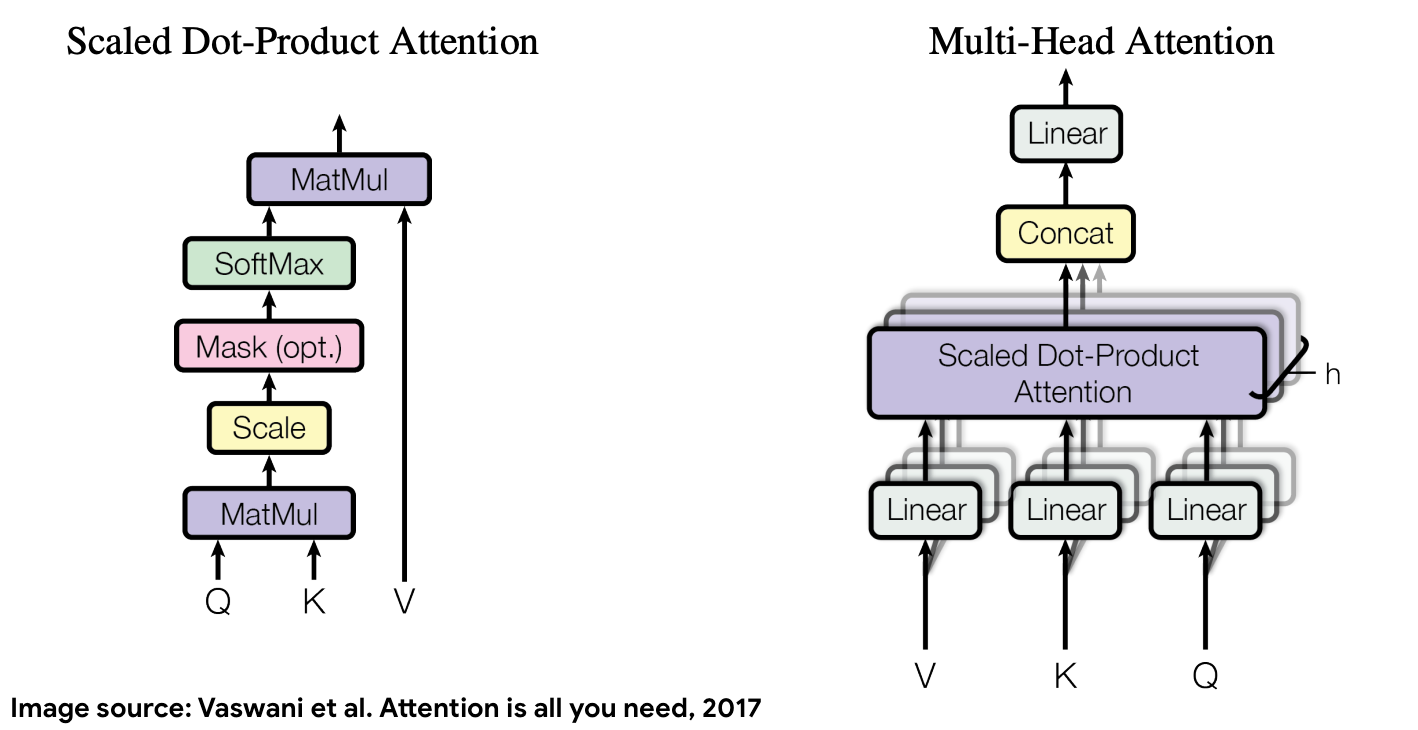

One analogy I find intuitive and helpful to understand how this work is:

*   Let’s say you are asked a question on a subject you are not familiar with at all, for example, quantum chemistry. The question is a query. You have no idea how to answer it, but what you can do is to go to a local library and read books on the subject.
*   There are many books in the quantum chemistry section, so you can’t read them all in detail. What you will do is to match the question against the book titles first. The more compatible or similar the query is to a book title, the more relevant that book’s content may be to the query question, which means you want to spend more time, or **attention** on that book.
*   So in this case, we have the book titles as the keys and the book content as the values. We use the compatibility or affinity of the query and the keys to compute the attention scores, and then based on the attention scores, take the weighted average of the values (which are the books' content), as the output, to answer the question.

Obviously this is a very simplified analogy and does not talk about the sequence of queries, masking, self-attention vs. cross-attention, and so on. But you get the idea 🙂

In practice you will perform the attention function in parallel and concatenate their output, which becomes 'Multi-Head Attention' (MHA) as shown in the right diagram. You can take a look at how the MHA is implemented in [KerasNLP](https://github.com/keras-team/keras-nlp/blob/master/keras_nlp/layers/cached_multi_head_attention.py#L24:7).

Another important element in the Transformer architecture is Positional Embedding. Since there is no recurrency or convolution in the Transformer architecture, Positional Embedding is used to inject token position information into the word embedding. In the interest of time, you are recommended to learn more about it in the original [paper](https://arxiv.org/pdf/1706.03762.pdf).

## GPT2CausalLM

Finally, `GPT2CausalLM` has a `predict()` funtion that outputs the next word prediction logits, which can be turned into probabilities through a softmax layer.

In [ ]:
prediction_logits = gpt2_lm.predict(["Today is a beautiful day"])
print(prediction_logits.shape)
print(prediction_logits[0])

Of course, `GPT2CausalLM` has the `generate()` function that generates the prediction text output by repeatedly sampling for the next word from the predicted probability, given the prompt. You have seen how to use it at the very beginning of this colab.

By the way, you may have noticed the word 'causal' in the model name. Transformers are "autoregressive" models: they generate text one token at a time and feed that output back to the input. To make this efficient, these models ensure that the output for each sequence element only depends on the previous sequence elements; the models are "causal".